In [2]:
import os
import csv
import librosa
import librosa.display
import torch
import numpy as np
from intervaltree import IntervalTree,Interval
import shutil
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_wavelet, estimate_sigma)

In [3]:
settings={}
settings['dataset']               ='podcastR2_mini'
settings['root_path']             = '/data/naveen/msda206/orca_project/orca_al'
#path to dataset folder
settings['data_source_path']      = os.path.join(settings['root_path'],'data_source',settings['dataset'])
settings['train_annotation']      = 'train.tsv'
settings['val_annotation']        = 'dev.tsv'
settings['test_annotation']       = 'test.tsv'
settings['mean_file']             = 'mean64.txt'
settings['invstd_file']           = 'invstd64.txt'
settings['media_folder']          = 'wav'

settings['train_media_path']      = os.path.join(settings['data_source_path'],'train_data',settings['media_folder'])
settings['train_anno_path']       = os.path.join(settings['data_source_path'],'train_data',settings['train_annotation'])
settings['val_anno_path']         = os.path.join(settings['data_source_path'],'train_data',settings['val_annotation'])
settings['mean_file_path']        = os.path.join(settings['data_source_path'],'train_data',settings['mean_file'])
settings['invstd_file_path']      = os.path.join(settings['data_source_path'],'train_data',settings['invstd_file'])

settings['samp_rate']             = 44100
settings['thr']                   = 0.1
settings['window_size']           = 2.45
settings['resample']              = True

# Follwoing functions are taken from [ORCA_CNN](https://github.com/axiom-data-science/OrcaCNN/blob/master/PreProcessing/preprocessing.py) repository

In [4]:
def audio_norm(data):
    '''Normalization of audio'''
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data - min_data) / (max_data - min_data + 1e-6)
    return data - 0.5


def mfcc(data, sampling_rate, n_mfcc):
    '''Compute mel-scaled feature using librosa'''
    data = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
    # data = np.expand_dims(data, axis=-1)
    return data

def apply_per_channel_energy_norm(data, sampling_rate):
    '''Compute Per-Channel Energy Normalization (PCEN)'''
    S = librosa.feature.melspectrogram(data, sr=sampling_rate)  # Compute mel-scaled spectrogram
    # Convert an amplitude spectrogram to dB-scaled spectrogram
    log_S = librosa.power_to_db(S, ref=np.max)
    pcen_S = librosa.core.pcen(S)
    return pcen_S

def wavelet_denoising(data):
    '''
    Wavelet Denoising using scikit-image
    NOTE: Wavelet denoising is an effective method for SNR improvement in environments with
              wide range of noise types competing for the same subspace.
    '''
    sigma_est = estimate_sigma(data, multichannel=True, average_sigmas=True)
    im_bayes = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='BayesShrink',
                               mode='soft')
    im_visushrink = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                    mode='soft')

    # VisuShrink is designed to eliminate noise with high probability, but this
    # results in a visually over-smooth appearance. Here, we specify a reduction
    # in the threshold by factors of 2 and 4.
    im_visushrink2 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 2)
    im_visushrink4 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 4)
    return im_bayes

def set_rate(audio, rate):
    '''Set sampling rate'''
    return audio.set_frame_rate(rate)


def show_specgram(data,chunk_stime,chunk_etime,wav_name,win_no,label,sr):
    plt.title('Spectrogram wav= %s chunk_no = %d \n is_orca= %r time_window= %.02f-%.02f'%(wav_name,int(win_no),bool(label),float(chunk_stime),float(chunk_etime)))
    ax = plt.gca()
    fig = plt.gcf()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(data)
    fig.set_size_inches(10, 10)
    plt.show()

In [5]:
def get_intervals_dict_podcast_r2(labelfile):
    interval_dict = dict()
    with open(labelfile) as f:
        
        for i,(wav,start,dur,loc,date,data_source,data_source_id) in enumerate(csv.reader(f, delimiter='\t')):
            if i == 0 or float(dur)< settings['thr']: continue
            start = float(start)
            dur   = float(dur)
            end   = start+dur
            if wav not in interval_dict.keys():
                interval_dict[wav]=IntervalTree()
            interval_dict[wav].add(Interval(start,end))
    return interval_dict


def get_wavpaths():
    all_train_dev_wavs = glob.glob(os.path.join(settings['train_media_path'],'*'))
    train_interval_dict = get_intervals_dict_podcast_r2(settings['train_anno_path'])
    all_train_wavs  = []
    all_val_wavs    = []

    for wav_path in all_train_dev_wavs:
        wav_name = os.path.basename(wav_path)
        if wav_name in train_interval_dict:
            all_train_wavs.append(wav_path)
        else:
            all_val_wavs.append(wav_path)

    return all_train_wavs,all_val_wavs

In [6]:
def process_data(wav_paths,window_size_t,interval_dict,target_sr,resample=True,pad_last=True):

    '''
    Algorithm-
    1- Read the wav_file
    2- calculate the window size = 2.45 sec * orginal_samp_rate
    3- if pad last == True then do padding at the end
    4- split the padded wav file to 2.45 sec chunks and check if chunks contain orca_call or not using interval Tree
    5- calculate STFT,pcen_S followed by wavelet denoising and create spectrograms(As done in OrcaCNN)
    6- Save wav chunks and spectrograms in wav and specs folder
    '''
    for wav_path in wav_paths:
        wav_name = os.path.basename(wav_path)
        orig_sr = librosa.get_samplerate(wav_path)
        data,orig_sr = librosa.load(wav_path,orig_sr)
        window_size = int(window_size_t*orig_sr)
        excess = len(data)%window_size
        
        if excess and window_size < len(data) and pad_last:
            n_pad = window_size - excess
            data = np.pad(data,(0, n_pad),'reflect')
        
        cum_stime =0
        intervals   = interval_dict[wav_name]
        if not resample:
            target_sr = orig_sr
                
        for win_no,curr_indx in enumerate(range(0,len(data),window_size)):
            data_chunk = data[curr_indx:curr_indx+window_size]
            chunk_stime = cum_stime
            chunk_etime = chunk_stime + len(data_chunk)/orig_sr
            if intervals.overlaps(chunk_stime, chunk_etime):
                label = 1
            else:
                label = 0
            cum_stime = chunk_etime

            if target_sr != orig_sr:
                data_chunk = librosa.resample(data_chunk,orig_sr,target_sr)


            pcen_S = apply_per_channel_energy_norm(data_chunk, target_sr)
            denoised_data = wavelet_denoising(pcen_S)

            wav,ext = os.path.splitext(wav_name)
            chunk_wav = '_'.join([wav,"%04d"%(win_no)])
            
            show_specgram(denoised_data,chunk_stime,chunk_etime,wav_name,win_no,label,settings['samp_rate'])
            
            
    
train_interval_dict = get_intervals_dict_podcast_r2(settings['train_anno_path'])
val_interval_dict = get_intervals_dict_podcast_r2(settings['val_anno_path'])


all_train_wavs,all_val_wavs = get_wavpaths()

------------x-------Processing training data------x----------------


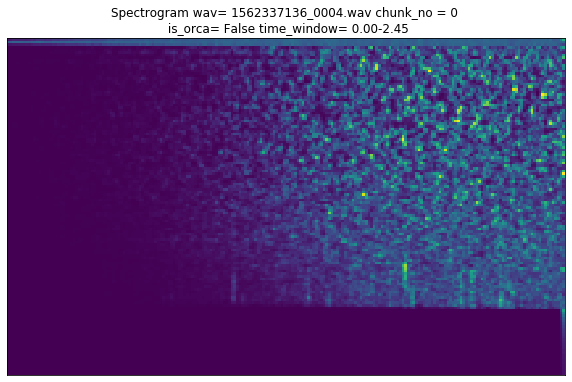

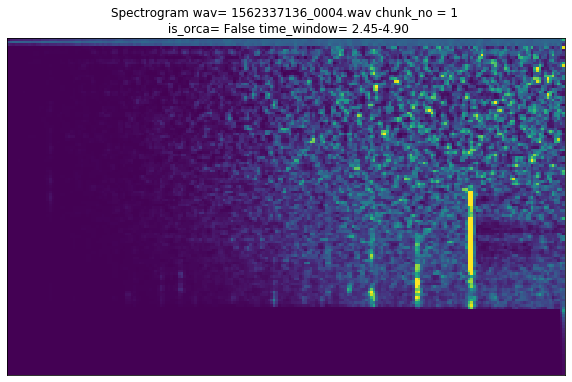

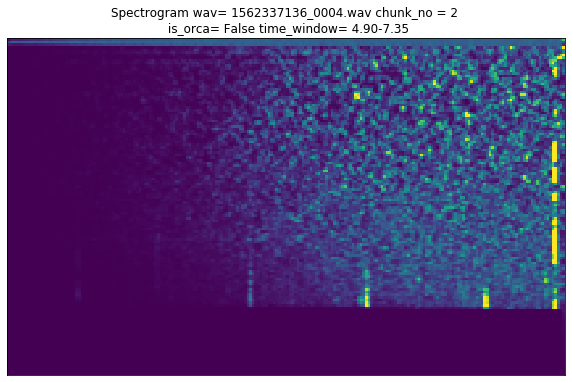

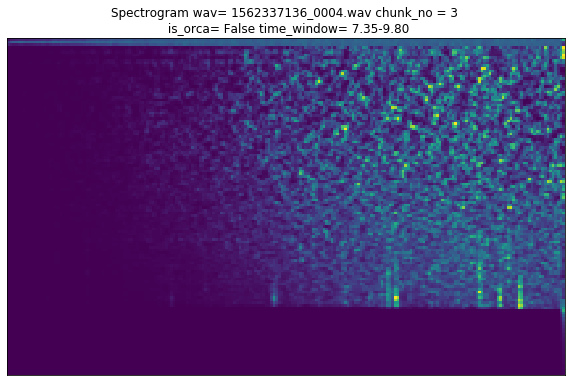

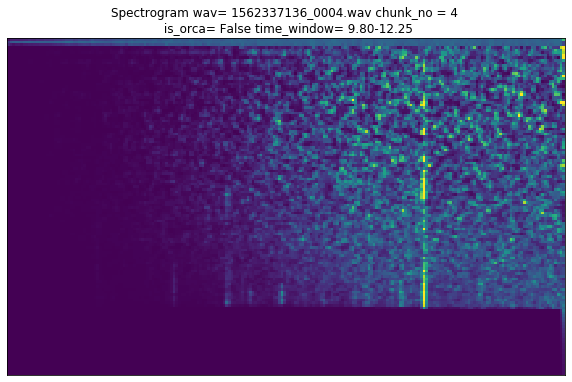

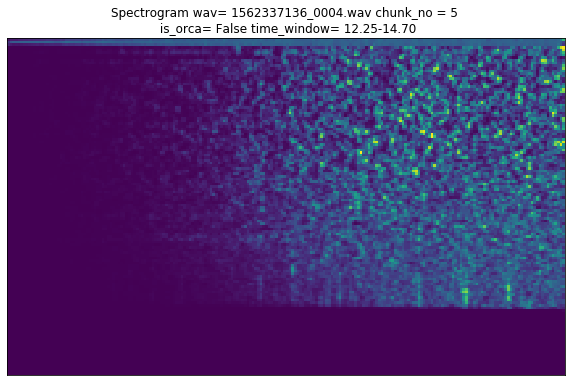

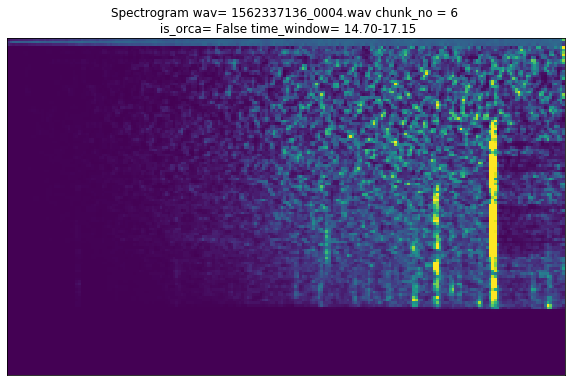

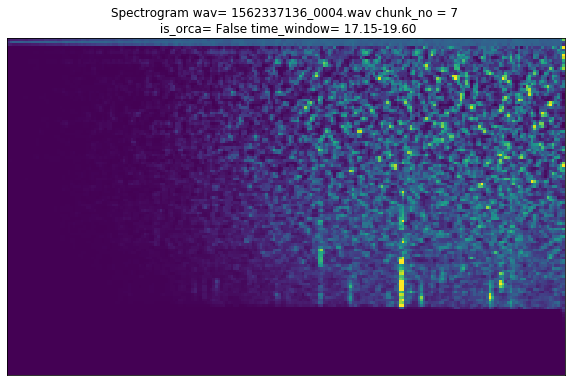

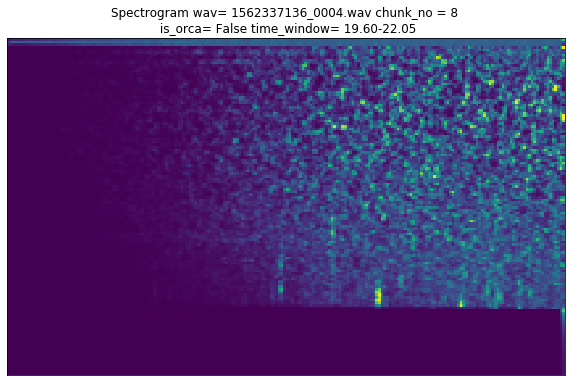

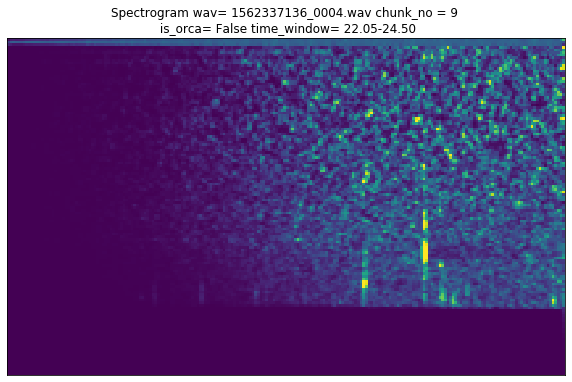

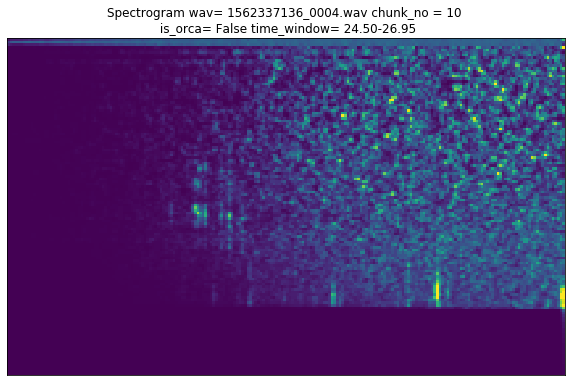

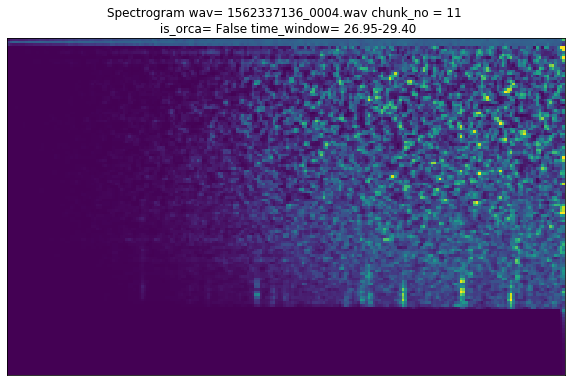

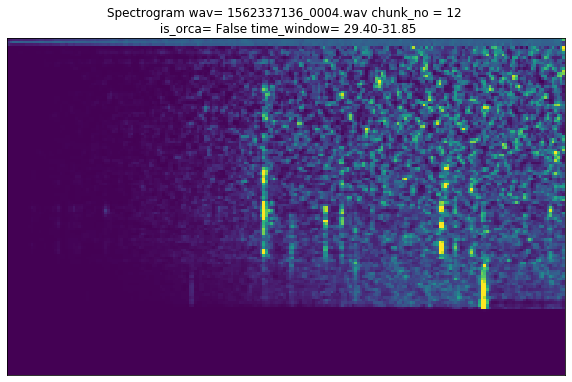

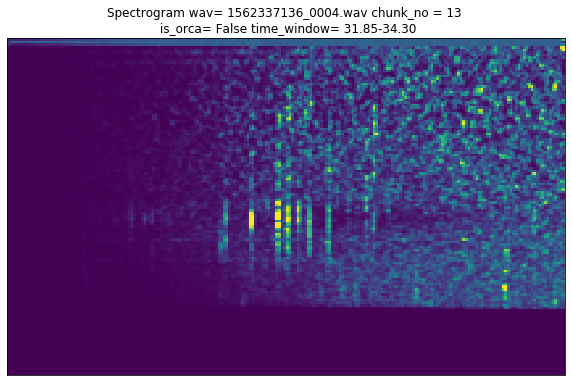

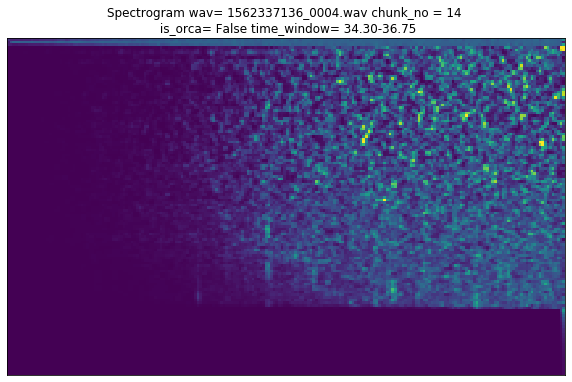

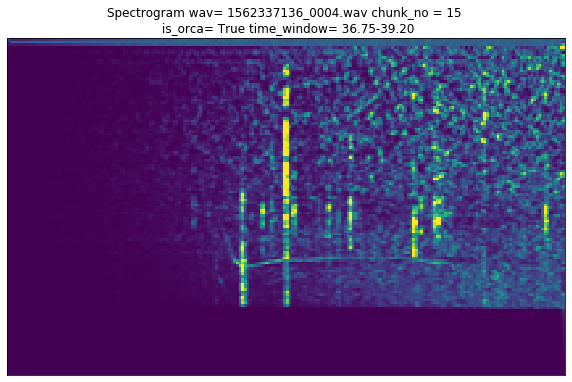

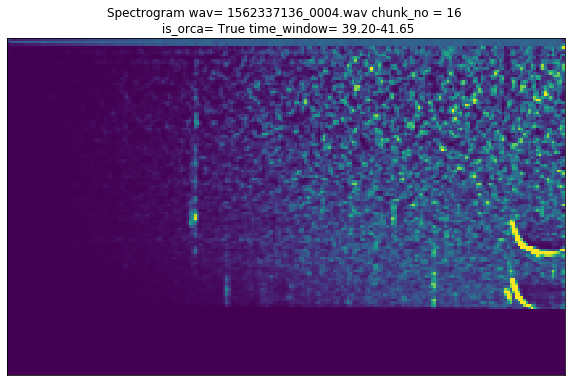

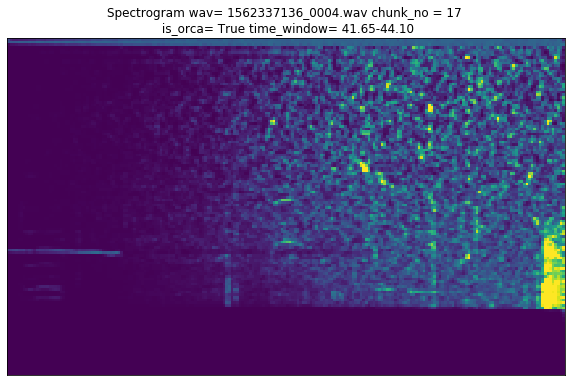

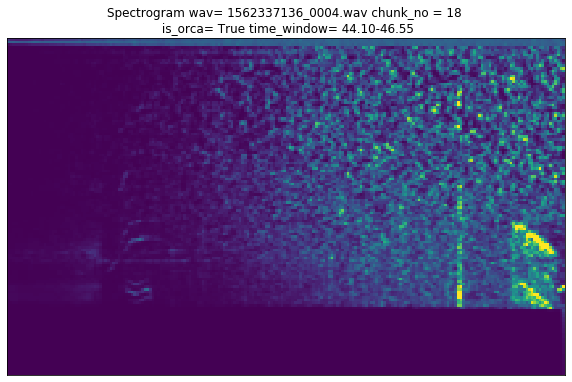

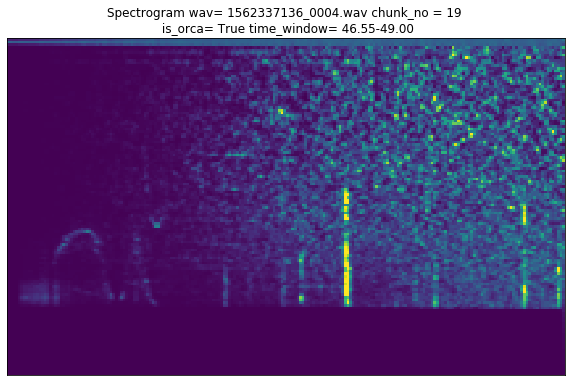

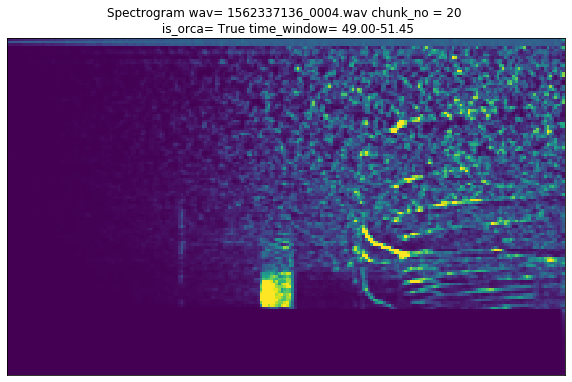

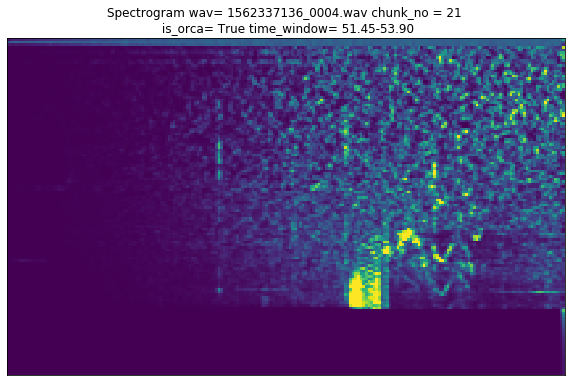

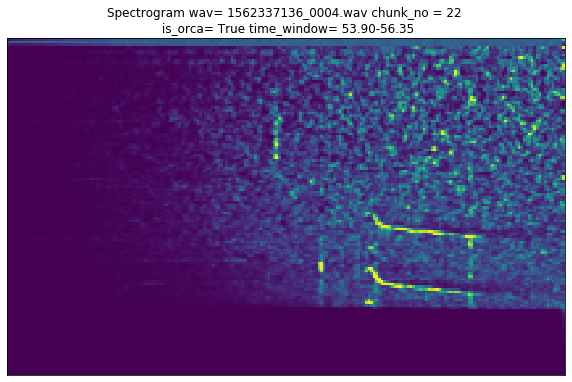

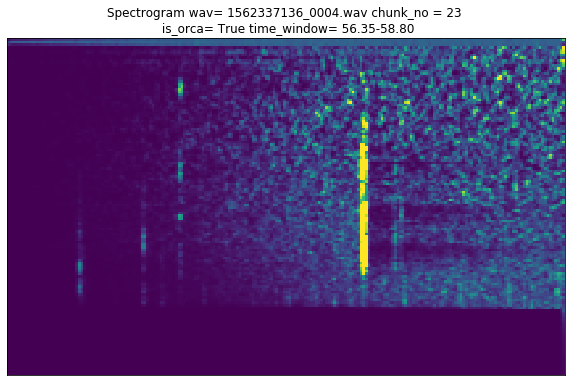

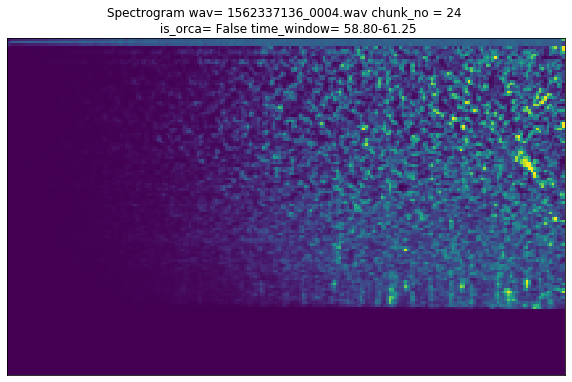

In [7]:

print('------------x-------Processing training data------x----------------')
process_data(all_train_wavs,settings['window_size'],train_interval_dict,settings['samp_rate'])

------------x-------Processing dev data------x----------------


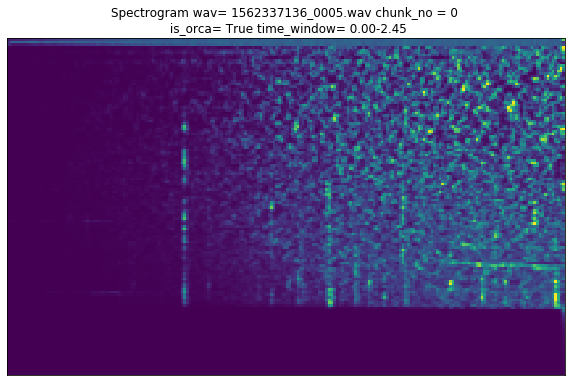

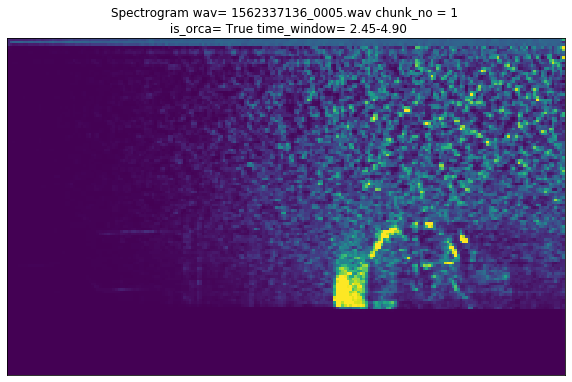

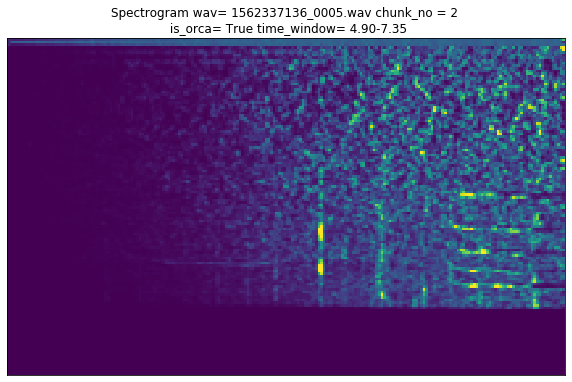

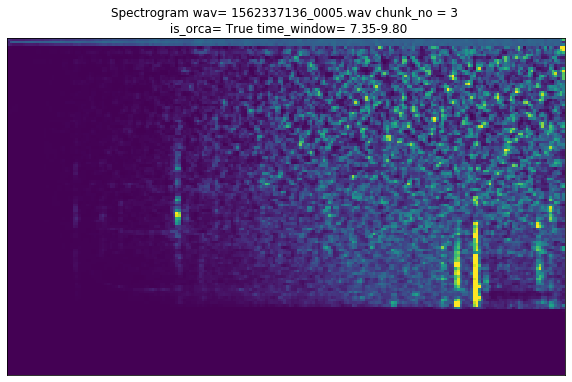

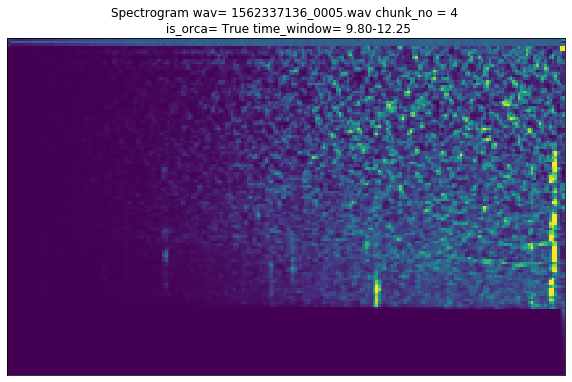

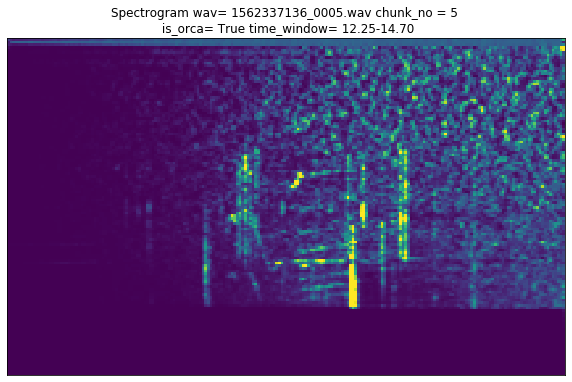

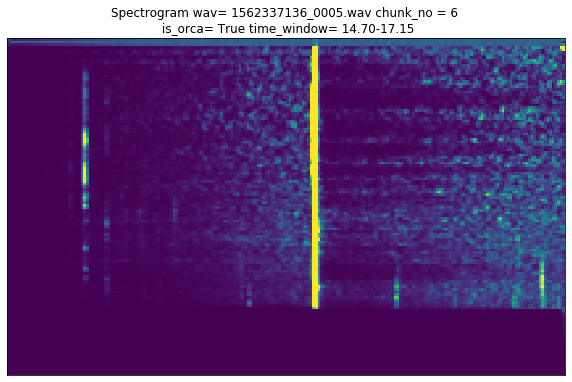

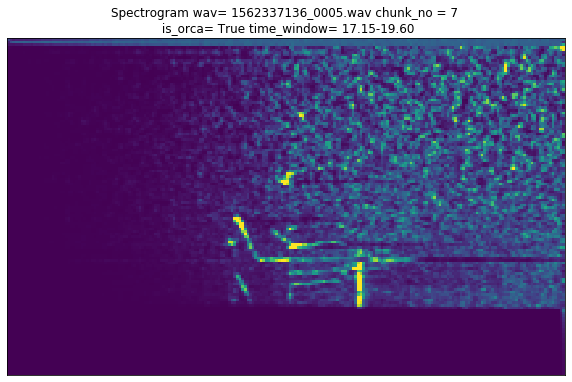

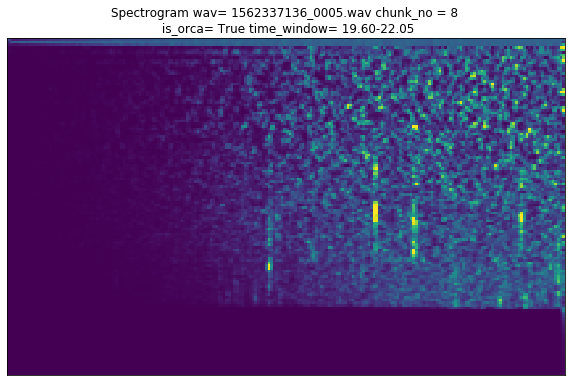

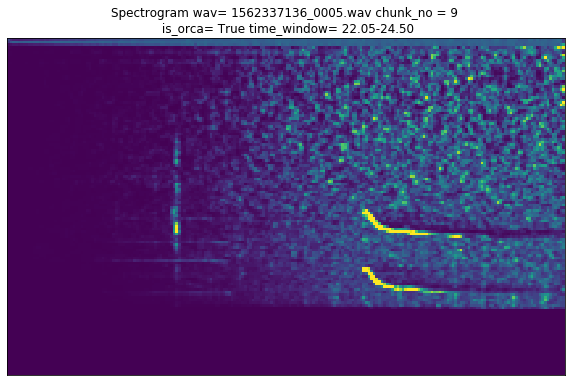

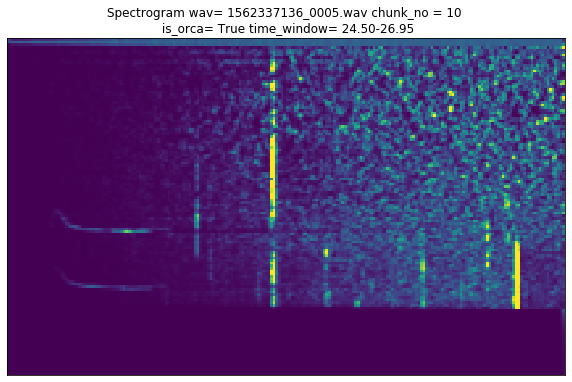

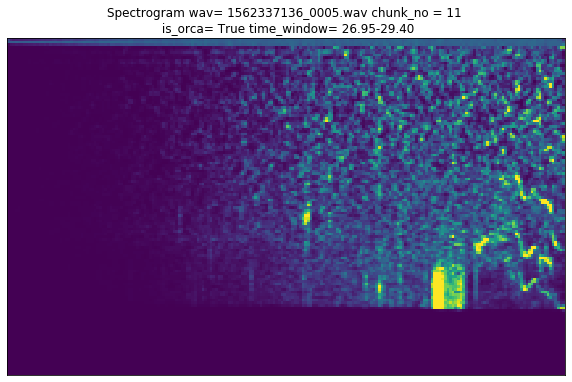

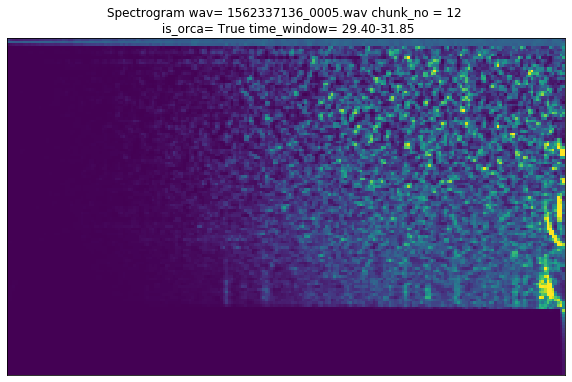

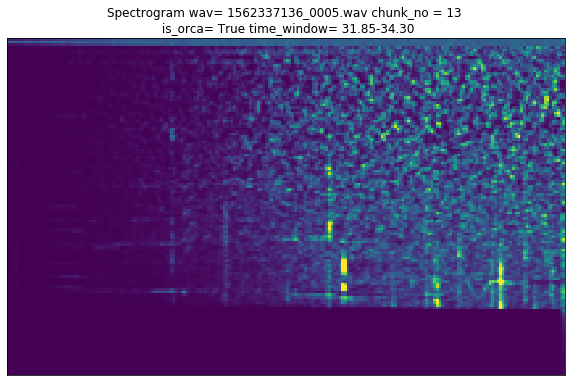

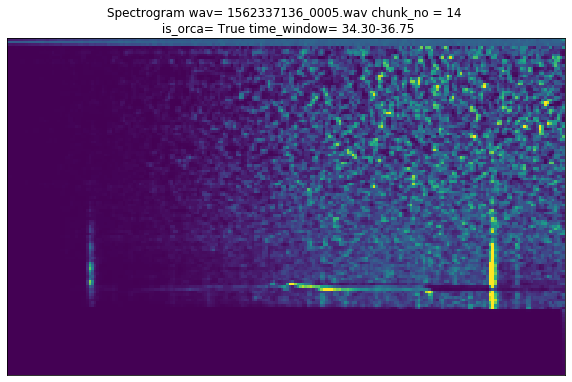

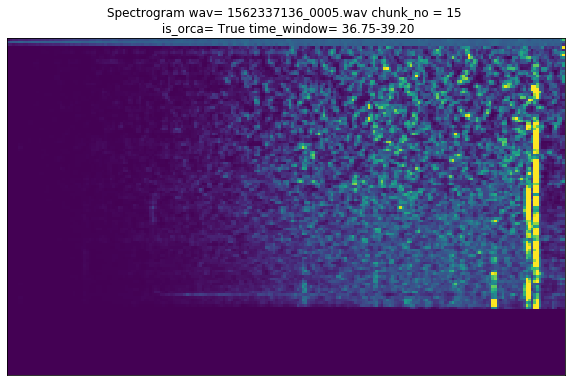

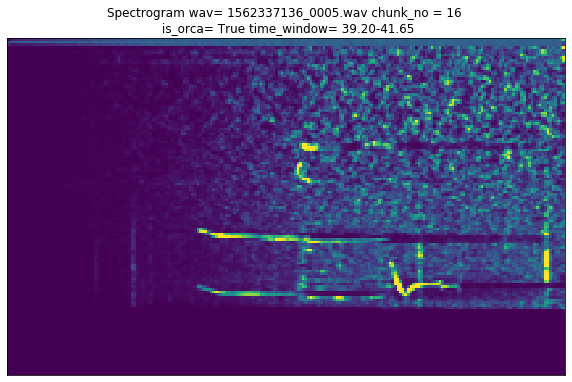

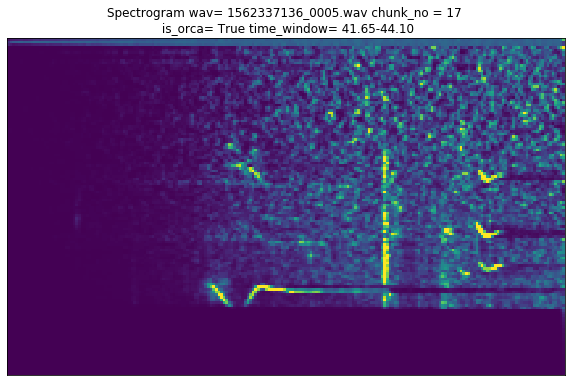

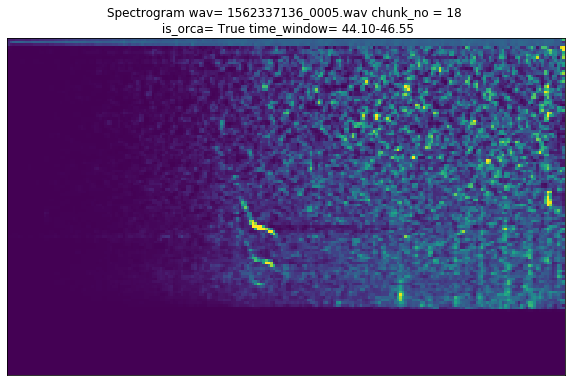

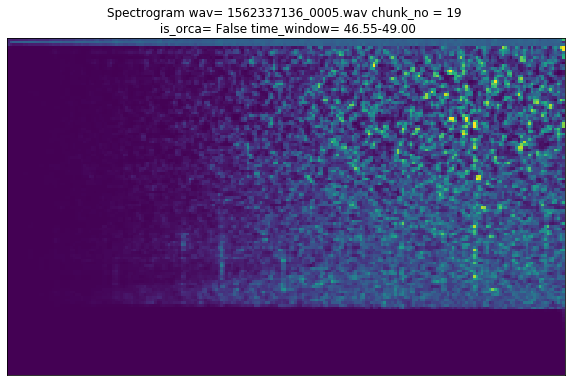

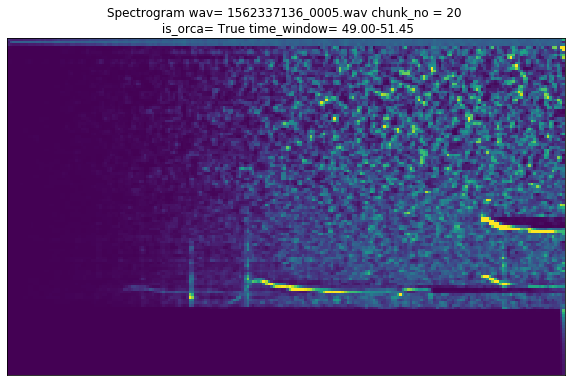

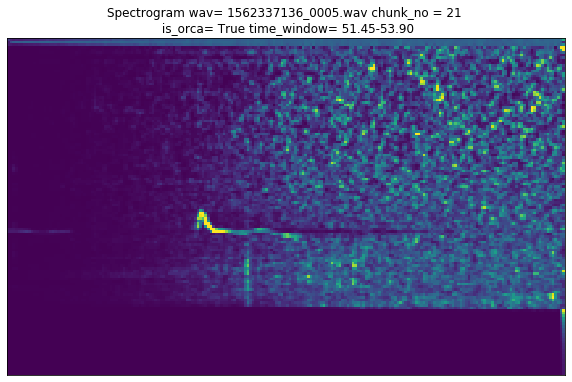

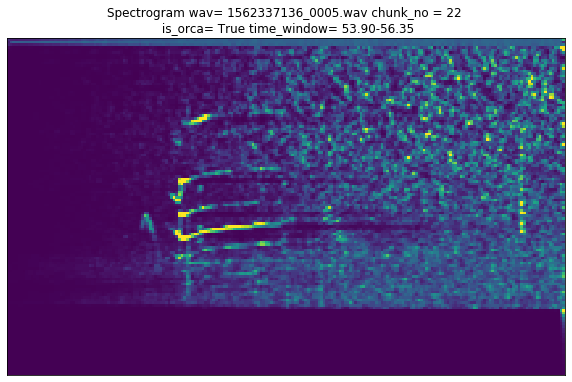

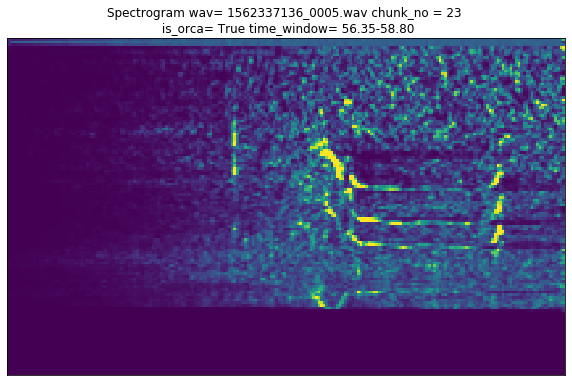

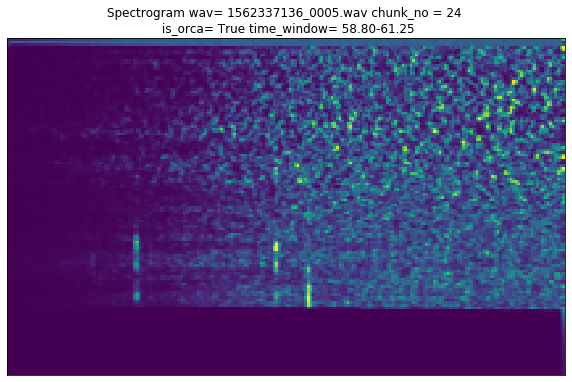

In [8]:
print('------------x-------Processing dev data------x----------------')
process_data(all_val_wavs,settings['window_size'],val_interval_dict,settings['samp_rate'])